In [2]:
import os
import random
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import cv2
import scipy.interpolate as interp
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy

from PIL import Image

from scipy.signal import lfilter

from src.preprocessing import speechproc
from src.preprocessing import spectrogating


import warnings
warnings.filterwarnings("ignore")
import glob
current_dir = os.getcwd() 

data = current_dir + '/Data/'
audio_dir = data + '/Raw_Audios/'
spectrogram_dir = data + '/Spectrograms/'
labeled_data_dir = data + '/Labeled_Data/'

### 1. import audio 

In [57]:
from src.audio import Audio

audio_filenames = glob.glob(audio_dir + '*')

audio = Audio.load(audio_filenames[2])
print('audio sample rate:', audio.sample_rate)
print('audio length of seconds:', audio.duration())


audio sample rate: 22050
audio length of seconds: 60.0


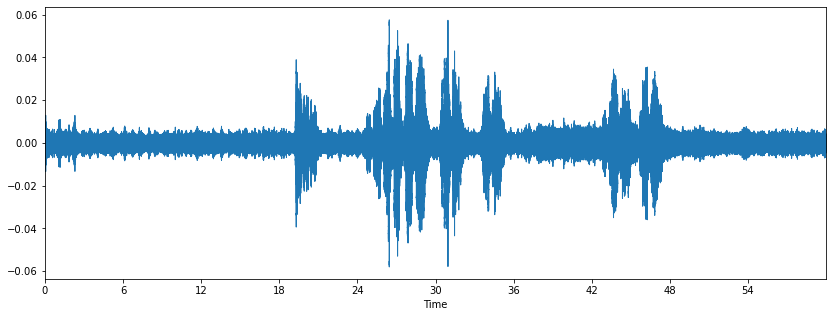

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio.samples, sr=audio.sample_rate, x_axis='time')


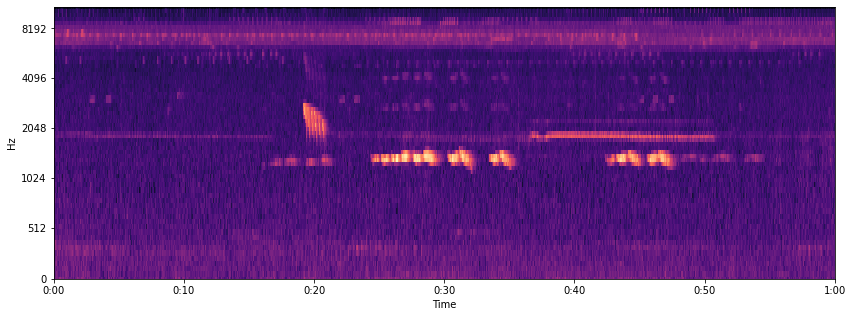

In [59]:
x_mel = librosa.feature.melspectrogram(y=audio.samples, sr=audio.sample_rate, n_mels=64)
x_mel_db = librosa.power_to_db(x_mel, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_mel_db, x_axis='time', y_axis='mel')

### 2. Preprocessing

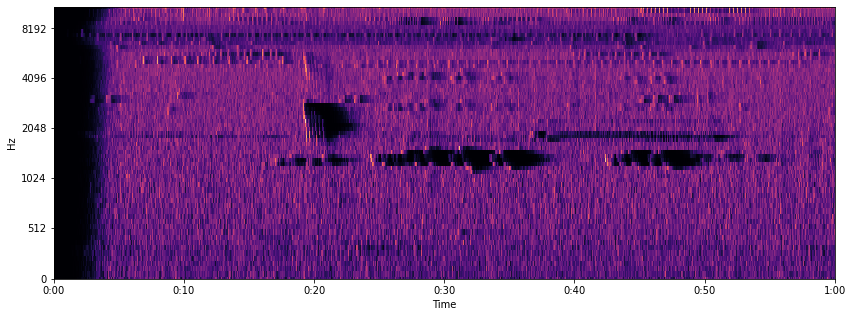

In [60]:
x_pcen = librosa.pcen(x_mel, sr=audio.sample_rate, gain=1.3, hop_length=512,
                      bias=2, power=0.3, time_constant=0.4, eps=1e-06, max_size=1)

plt.figure(figsize=(14, 5))
librosa.display.specshow(x_pcen, x_axis='time', y_axis='mel')

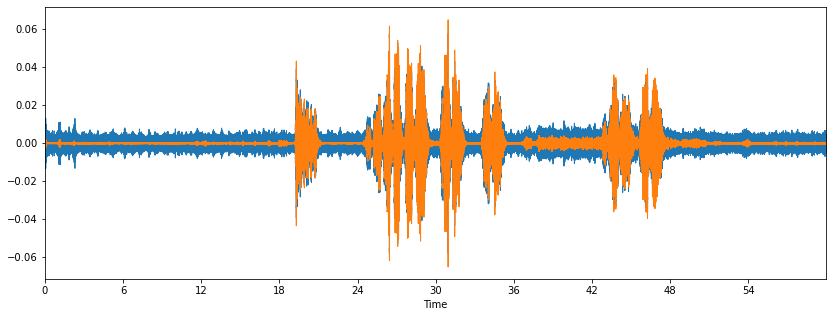

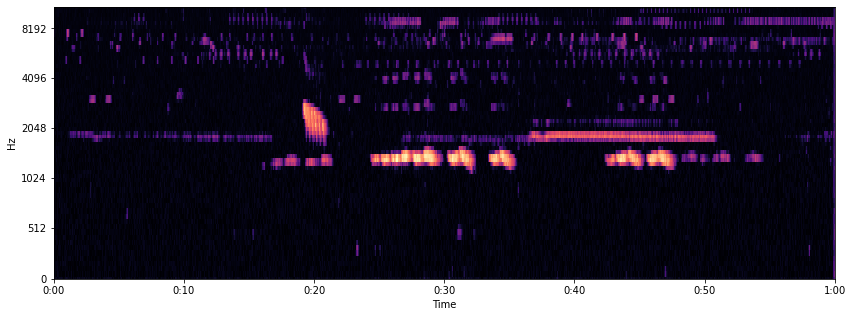

In [61]:
noise = audio.samples[0:1*audio.sample_rate]
x_dn = spectrogating.removeNoise(audio_clip=audio.samples, noise_clip=noise,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=2.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio.samples, sr=audio.sample_rate, x_axis='time');
librosa.display.waveplot(x_dn,sr=audio.sample_rate, x_axis='time');

x_mel_dn = librosa.feature.melspectrogram(y=x_dn, sr=audio.sample_rate, n_mels=64)
x_mel_dn_db = librosa.power_to_db(x_mel_dn, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_mel_dn_db, x_axis='time', y_axis='mel')
#plt.axis('off')

### 3. Sound Event Detection

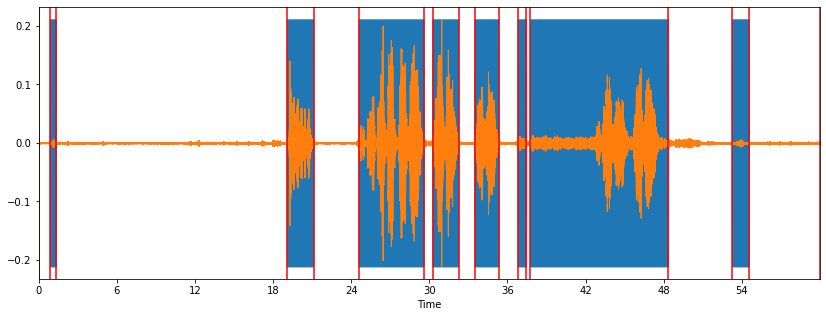

In [94]:
winlen, ovrlen, pre_coef, nfilter, nftt = 0.025, 0.01, 0.97, 20, 2048
ftThres = 0.4
vadThres = 0.2
opts = 1

# %%
ft, flen, fsh10, nfr10 = speechproc.sflux(x_dn, sr, winlen, ovrlen, nftt)

# --spectral flatness --
pv01 = np.zeros(nfr10)
pv01[np.less_equal(ft, ftThres)] = 1 
pitch = deepcopy(ft)
pvblk = speechproc.pitchblockdetect(pv01, pitch, nfr10, opts)


# --filtering--
ENERGYFLOOR = np.exp(-50)
b = np.array([0.9770,   -0.9770])
a = np.array([0.3,   -0.3])
fdata = lfilter(b, a, x_dn, axis=0)

vad_seg = speechproc.snre_vad(fdata, nfr10, flen, fsh10, ENERGYFLOOR, pv01, pvblk, vadThres)



import scipy.interpolate as interp
interp = interp.interp1d(np.arange(vad_seg.size), vad_seg)
vad_seg_st = interp(np.linspace(0, vad_seg.size-1, fdata.size))

# %%
plt.figure(figsize=(14, 5))
librosa.display.waveplot(vad_seg_st.astype('float') * fdata.max(), sr=sr, x_axis='time')
librosa.display.waveplot(fdata, sr=sr, x_axis='time')


no_events_starttime = [0] + [i / len(vad_seg) * audio.duration() for i in range(len(vad_seg)) if vad_seg[i] == 0 and vad_seg[i-1] == 1]
no_events_endtime = [i / len(vad_seg) * audio.duration() for i in range(len(vad_seg)) if vad_seg[i] == 1 and vad_seg[i-1] == 0] + [audio.duration()]

for x in no_events_starttime:
    plt.axvline(x=x, color = 'red')

for x in no_events_endtime:
    plt.axvline(x=x, color = 'red')